In [90]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [91]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [92]:
# df = pd.read_csv("edd_cf4_refined.csv", sep='|')
df = pd.read_csv("btfr_brent_updated.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df = df.rename(columns={"e_F21":"eF21"})

df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['flag', 'DM_av', 'eDM', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'DM_75',
       '1PGC', 'Nest', 'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel',
       'Vls', 'v3k', 'f', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc',
       'g***', 'r***', 'i***', 'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE',
       'GLong', 'GLat', 'SGL', 'SGB', 'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg',
       'Vlsg', 'V3kg', 'fg'],
      dtype='object')
10153


,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,SGL,SGB,Nkt,N15,SGLg,SGBg,Vhg,Vlsg,V3kg,fg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.11,73150,200275.0,...,341.6440,20.7388,0,7,341.4922,20.7395,5194,5486,4916,1.013
4,1,33.49,0.38,33.44,0.19,33.54,0.19,33.72,120,202766.0,...,316.0587,18.4514,0,0,316.0587,18.4514,4458,4706,4109,1.011
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.61,12,210177.0,...,286.4249,11.3511,0,1,286.4249,11.3510,6532,6669,6179,1.016
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.30,16,211419.0,...,287.6119,11.7030,0,1,287.6120,11.7030,5709,5851,5354,1.014
55,1,33.71,0.43,33.70,0.26,33.71,0.25,33.89,55,NaN,...,327.0996,19.7763,0,0,327.0996,19.7763,4779,5052,4454,1.012


In [93]:
df['Vmod'] = df.Vlsg # df.fg*df.Vlsg   # df.f*df.v3k # 
df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.D75)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [94]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [95]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

,Flux
PGC,
2,4.73
4,1.85
6,NaN
10,2.47
12,3.40


In [96]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

df = df.rename(columns={"Vls":"V3k"})

df.head()

,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,logD75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,gi,F,e_F,Flux
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.320973,73150,200275.0,...,1.864195,NaN,NaN,NaN,NaN,-22.430973,NaN,NaN,NaN,4.73
4,1,33.49,0.38,33.44,0.19,33.54,0.19,33.987953,120,202766.0,...,1.797591,-18.397953,-18.657953,-18.867953,-18.917953,-17.917953,0.47,1.96,0.07,1.85
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.744997,12,210177.0,...,1.948999,NaN,NaN,NaN,NaN,-21.154997,NaN,NaN,NaN,3.40
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.460844,16,211419.0,...,1.892169,-20.100844,-20.600844,-20.880844,-21.060844,-20.470844,0.78,NaN,NaN,1.19
55,1,33.71,0.43,33.70,0.26,33.71,0.25,34.142010,55,NaN,...,1.828402,-18.612010,-18.822010,-18.922010,-18.972010,-17.942010,0.31,NaN,NaN,4.30


In [97]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
dg.loc[adhi_list]['F21_'] = dg.loc[adhi_list].Flux   # using ADHI HI flux values


len(dg)

# df["F21"] = dg.F21_
# df["eF21"] = dg.F21_e

<ipython-input-97-69eae98da3b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
<ipython-input-97-69eae98da3b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


10153

In [98]:
new_drop = pd.read_csv("drop_january2021.bar", sep='|')

df = df.drop(new_drop.PGC.values, errors='ignore')

len(df)

10153

In [99]:
calib = pd.read_csv("../calibrators/allzpa_labels.csv", sep=',')

for col in calib.columns:
    newcol = col.strip()
    calib.rename(columns={col:newcol}, inplace=True)
    
calib_weird = [68535, 28378, 42081, 39461, 44536]
calib['Name']=calib.apply(lambda x: None if x.PGC in calib_weird else x.Name, axis=1)
            
calib.set_index('PGC', inplace=True)

calib = calib.join(df[["V3k", "Vmod", "Qs", "Qw", "F21", 'eF21', 'elgWi', 'g***', 'r***', 'i***', 'z***']]).dropna()
calib = calib[(calib.Qs>2) & (calib['i']>0)]

calib['Dist'] = 10**((calib.dm19-25)/5.)
calib['Mass_HI'] = 2.356E5 * calib.F21 * (calib.Dist**2)


for waveband in ['g***','r***','i***','z***']:
    calib[waveband] = calib.apply(lambda x: x[waveband] if x[waveband]!=0 else np.nan, axis=1)
for waveband in ['g','r','i','z']:
    calib[waveband+'***'] = calib.apply(lambda x: x[waveband+'***'] if x[waveband]!=0 else np.nan, axis=1)

calib['Mr'] = calib['r***']-calib.dm19
calib['Mi'] = calib['i***']-calib.dm19
calib['Mz'] = calib['z***']-calib.dm19
calib['gi'] = calib["g***"]-calib['i***']


calib['logMs_i']  = 1.619 + 0.510*calib.gi - 0.4*calib['Mi']
calib['logMs_r']  = 1.617 + 0.650*calib.gi - 0.4*calib['Mr']
calib['logMs_z']  = 1.610 + 0.461*calib.gi - 0.4*calib['Mz']


alfa = 0.536
beta = 1.616
calib['logMs_riz'] = beta + alfa*calib.gi - 0.4*calib[["Mr", "Mi", "Mz"]].mean(axis=1)

calib['Ms_riz'] = 10**calib.logMs_riz
calib = calib.dropna()

print(len(calib))
calib.head()

45


,So,Name,dm19,inc,lgWmxi,eWi,Mu,Mg,Mr,Mi,...,i***,z***,Dist,Mass_HI,gi,logMs_i,logMs_r,logMs_z,logMs_riz,Ms_riz
PGC,,,,,,,,,,,,,,,,,,,,,
21396,2,NGC2403,27.514,58,2.454,0.026,-18.56,-19.43,-19.704,-19.854,...,7.66,7.64,3.182731,3.273213e+09,0.42,9.7748,9.7716,9.75322,9.765387,5.826217e+09
28357,2,NGC3021,32.327,58,2.454,0.022,-19.11,-20.11,-20.617,-20.897,...,11.43,11.30,29.201153,2.535331e+09,0.79,10.3807,10.3773,10.38499,10.378240,2.389131e+10
32192,2,NGC3368,30.165,52,2.630,0.024,-19.29,-20.67,-21.355,-21.715,...,8.45,8.31,10.789467,2.248998e+09,1.04,10.8354,10.8350,10.83144,10.830107,6.762490e+10
32207,2,NGC3370,32.149,56,2.514,0.021,-19.43,-20.22,-20.589,-20.779,...,11.37,11.30,26.902956,4.424994e+09,0.56,10.2162,10.2166,10.20776,10.211760,1.628396e+10
34695,2,NGC3627,30.125,64,2.605,0.015,-20.04,-21.16,-21.715,-21.985,...,8.14,7.99,10.592537,1.206747e+09,0.82,10.8312,10.8360,10.84202,10.833520,6.815850e+10


In [100]:
# calib.loc[26317].head(20)

In [101]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [102]:
gamma = np.log10(0.5) + 0.4*5.91
df['logMs_W1'] = gamma - 0.4*df['M1_75']
df['Ms_W1'] = 10**df.logMs_W1

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

df['logMs_i']  = 1.619 + 0.510*df.gi - 0.4*df['Mi_75']
df['logMs_r']  = 1.617 + 0.650*df.gi - 0.4*df['Mr_75']
df['logMs_z']  = 1.610 + 0.461*df.gi - 0.4*df['Mz_75']

alfa = 0.536
beta = 1.616
df['logMs_riz'] = beta + alfa*df.gi - 0.4*df[["Mr_75", "Mi_75", "Mz_75"]].mean(axis=1)
df['Ms_riz'] = 10**df.logMs_riz

In [103]:
m = 1.684
b = -3.152
mc = -6.12e-05
def HI_corrector(mc, bc, V3k):
    return mc*V3k+bc

[ 6.93729844e-09 -8.50583069e-05  5.64263059e-01 -1.36940291e+03]


<ipython-input-104-bfc401c7aed0>:3: RuntimeWarning: divide by zero encountered in log10
  Y0 = dff.logMs_riz.values-np.log10(dff.Mass_HI.values)


Text(18000.0, -0.12, '$\\times 10^{3}$')

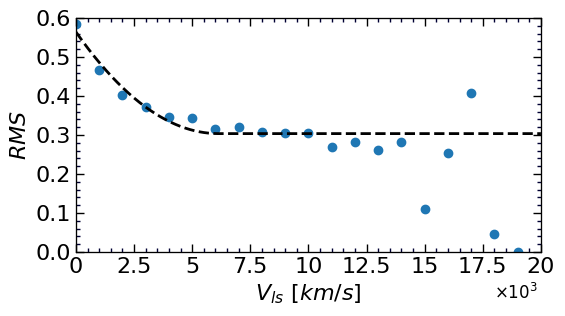

In [104]:
dff = df[((df.Qw>2)|(df.Qs>2))&(df.elgWi>0)&(df.lgWmxi>0)]
X0 = dff.lgWmxi.values
Y0 = dff.logMs_riz.values-np.log10(dff.Mass_HI.values)
V3k = dff.V3k.values

fig = py.figure(figsize=(5,3), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

Y = Y0-(m*X0+b)
X = V3k

X = X[X0>2.2]
Y = Y[X0>2.2]


def rms(x, a, b, c, x0):
    
    y = a*x**2+b*x+c
    
    x0 = x0+7500
    
    y0 = a*x0**2+b*x0+c
    
    try:
        y[x>x0] = y0
    except:
        if x>x0:
            y=y0
    
    return y
    


xx = []
yy = []
for b in range(0, 20000, 1000):
    delta = Y -  mc * X
    delta = delta[((delta<10)&(delta>-10)&(X<b+1000)&(X>b))]
#     print(np.std(delta))
    
    
    xx.append(b)
    yy.append(np.std(delta))

xx = np.asarray(xx)
yy = np.asarray(yy)
ax.plot(xx, yy, 'o')

fit, cov = curve_fit(rms, xx[xx<13000], yy[xx<13000])

x = np.linspace(0,20000,1000)

print(fit)

ax.plot(x, rms(x, fit[0], fit[1], fit[2], fit[3]), 'k--', lw=2)

ax.set_ylabel(r'$RMS$', fontsize=16) 

ax.set_xlabel(r'$V_{ls} \/\/ [km/s] $', fontsize=16)


Cadj_rms = fit

set_axes(ax, (0, 20000), (0,0.6), fontsize=16)


import matplotlib.ticker as ticker
# Change only ax2
scale_x = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax.xaxis.set_major_formatter(ticks_x)

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.1*Xlm[0]+0.9*Xlm[1]
y0 = 1.20*Ylm[0]-0.20*Ylm[1]
ax.text(x0,y0, r"$\times 10^{3}$", fontsize=12, color='k')

In [105]:
Cadj_rms

array([ 6.93729844e-09, -8.50583069e-05,  5.64263059e-01, -1.36940291e+03])

In [106]:
fit[3]+7500

6130.59709112891

In [53]:
df['Mb'] = df.Ms_W1 + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dMs = df.Ms_W1.values * np.log(10.) * np.sqrt(0.1**2+(0.4*0.1)**2)
dx = np.sqrt((df.eF21/df.F21/np.log(10))**2+(0.2E-5 * df.V3k.values)**2)
dTwiddle_Mhi = np.log(10.) * 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values))) * dx

dMb = np.sqrt(dMs**2+dTwiddle_Mhi**2)

df['dMb'] = dMb
df['dMs'] = dMs

df['dlogMb'] = dMb / df.Mb / np.log(10.)
df['dlogMs'] = dMs / df.Ms_W1 / np.log(10.)

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


3.418 10.359


<ipython-input-18-bbfa2006e28d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


<ErrorbarContainer object of 3 artists>

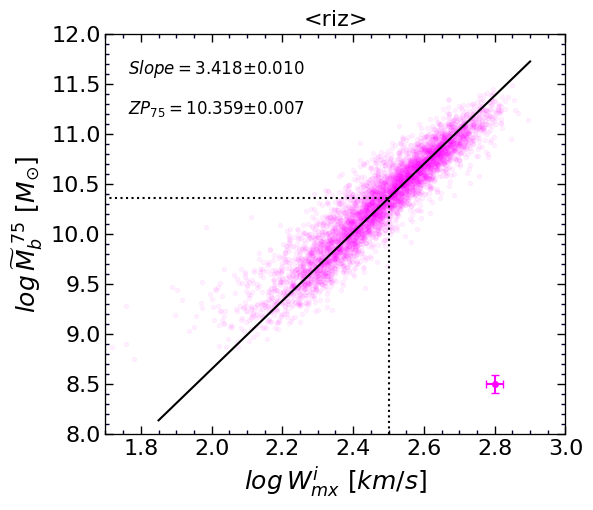

In [18]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

m0 = 3.418
b0 = 10.359
dm0 = 0.010
db0 = 0.007
    
logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

##################################################################

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass, '.', color='magenta', alpha=0.05) 


w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'k-')
print(m0,b0)    
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{\/\/75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.9*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.8*Ylm[1]
ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')

ax.plot([2.5,2.5], [8, b0], 'k:')
ax.plot([0,2.5], [b0, b0], 'k:')

ye = np.nanmean((dff.dlogMb).dropna().values)
xe = np.nanmean((dff.elgWi).dropna().values)

ax.errorbar([2.8],[8.5], xerr=xe, yerr=ye, fmt='o', 
                    color='magenta', ms=4, capsize=3, mfc='magenta')

3.418 10.359


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-19-8ea801750214>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


<ErrorbarContainer object of 3 artists>

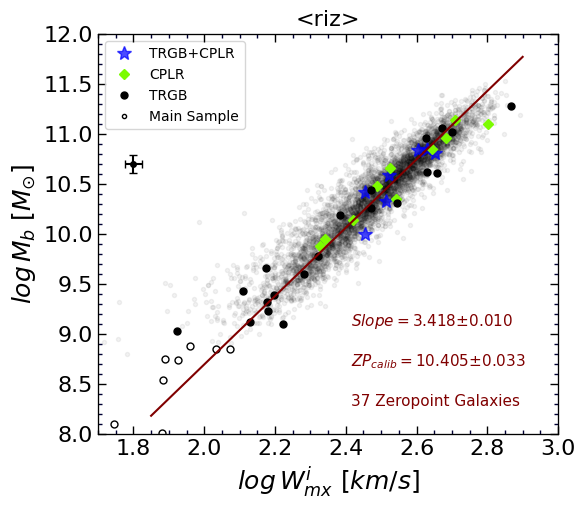

In [19]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

calib['Mb'] = calib.Ms_riz + 1.33*(10**(np.log10(calib.Mass_HI)+HI_corrector(mc, 0, calib.V3k.values)))
calib['logMb'] = np.log10(calib.Mb.values)


dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

m0 = 3.418
b0 = 10.359
dm0 = 0.010
db0 = 0.007
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

##################################################################
def linear_zp(x, zp):
    
    return x/m0+zp

X = calib.lgWmxi.values
Xe = calib.elgWi.values
Y = calib.logMb.values
BB = calib['logMb']
So = calib.So.values

fit, cov = curve_fit(linear_zp, Y[BB>9], X[BB>9]-2.5, sigma=np.sqrt(Xe[BB>9]**2+(0.01)**2))
zp_calib = -fit[0]*m0
zp_calib_e = np.sqrt(cov[0][0])*m0

zp_calib_e = np.sqrt(zp_calib_e**2+db0**2)

zp_calib += 0.044


logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass-b0+zp_calib, '.', color='k', alpha=0.05) 

ind, = np.where((BB<9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', mfc='white') 
ind, = np.where((BB>9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', alpha=0.7, label='TRGB+CPLR') 


ind, = np.where((BB<9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', mfc='white') 
ind, = np.where((BB>9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', alpha=1.0, label='CPLR') 


ind, = np.where((BB<9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', mfc='white') 
ind, = np.where((BB>9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', label='TRGB') 

ax.plot([0], [0], '.', color='k', label='Main Sample', mfc='white') 
#######################################################################

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, '-', color='maroon')
print(m0,b0)    

    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$log \/ M_b \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
# x0 = 0.95*Xlm[0]+0.05*Xlm[1]
# y0 = 0.1*Ylm[0]+0.9*Ylm[1]
# ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
# y0 = 0.2*Ylm[0]+0.8*Ylm[1]
# ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.45*Xlm[0]+0.55*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, "%d"%len(Xe[BB>9])+' Zeropoint Galaxies', fontsize=11, color='maroon')
y0 = 0.83*Ylm[0]+0.17*Ylm[1]
ax.text(x0,y0, r"$ZP_{calib} = $"+"%.3f" % zp_calib+'$\pm$'+"%.3f" % zp_calib_e, fontsize=11, color='maroon')
y0 = 0.73*Ylm[0]+0.27*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=11, color='maroon')

ax.legend(loc=2)

ax.errorbar([1.8],[10.7], xerr=xe, yerr=ye, fmt='o', 
                    color='k', ms=4, capsize=3, mfc='k')

In [20]:
np.std(Y[(Y<11.5)&(Y>9.0)] - (m0*(X[(Y<11.5)&(Y>9.0)]-2.5) + zp_calib))

0.20547138898150993

In [21]:
std

10000000000.0

In [22]:
b0 = zp_calib
b0

10.405048307871825

718
758
53


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-23-aec63deee2d3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


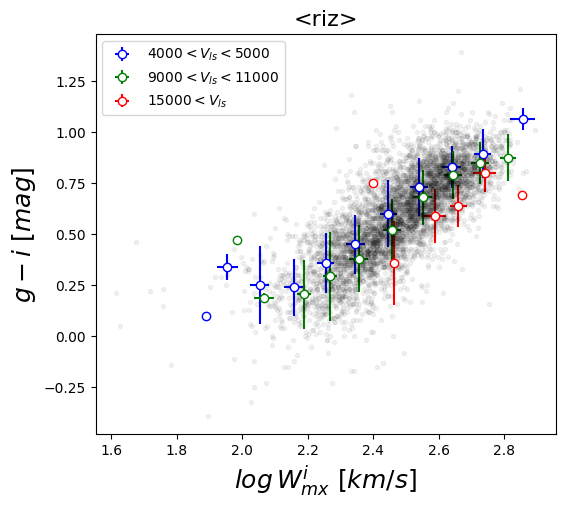

In [23]:
df['Mb0'] =  1.33*(10**(np.log10(df.Mass_HI)))
# df['logMb0'] = np.logD75 # np.log10(df.Mb0.values)

df['Vmod'] = df.Vlsg # df.fg*df.Vlsg   # df.f*df.v3k # 
df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.D75)
df['DM_75'] = 5*df.logD75 + 25 

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.gi.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{ls}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{ls}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{ls}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$g-i \/\/ [mag]$', fontsize=18)
# set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

ax.legend()

# ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

718
758
53


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-24-37cde12d31d3>:2: RuntimeWarning: divide by zero encountered in log10
  df['logMb0'] = np.log10(df.Mb0.values)
<ipython-input-24-37cde12d31d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


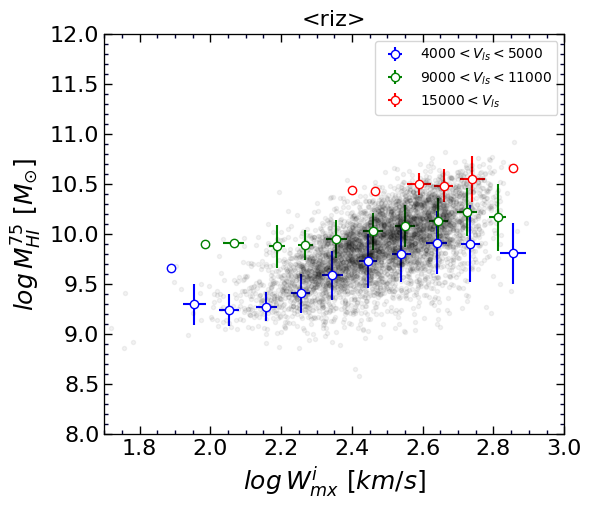

In [24]:
df['Mb0'] =  1.33*(10**(np.log10(df.Mass_HI)))
df['logMb0'] = np.log10(df.Mb0.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb0.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{ls}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{ls}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{ls}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_{HI}^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

ax.legend()

# ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

718
758
53


<ipython-input-25-a0d5afec4746>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


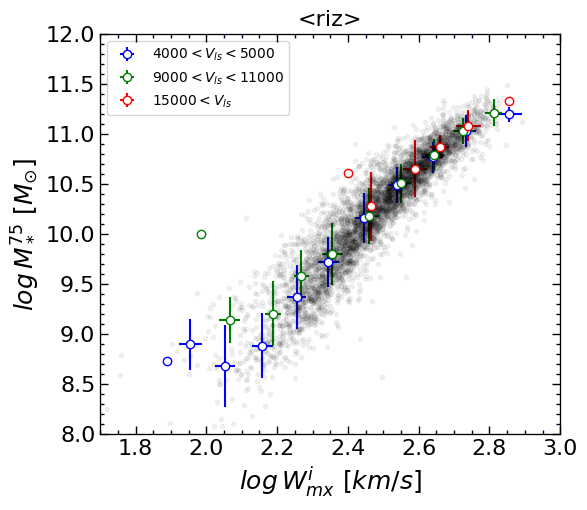

In [25]:
df['Mb0'] = df.Ms_riz # + 1.33*(10**(np.log10(df.Mass_HI)))
df['logMb0'] = np.log10(df.Mb0.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb0.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{ls}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{ls}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{ls}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

ax.legend()

# ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

718
758
53


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-26-31b87acd8410>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


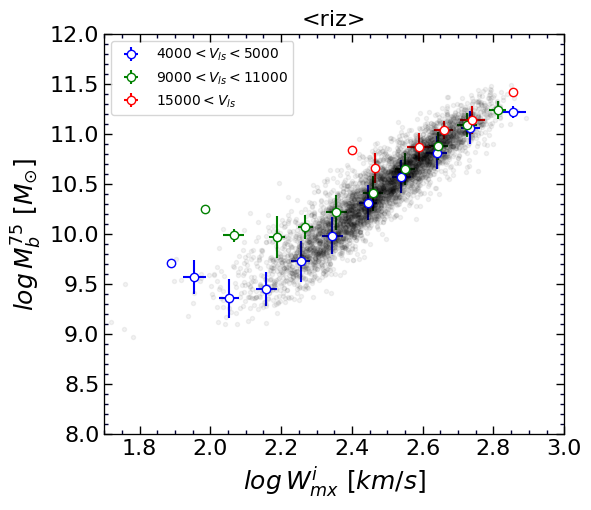

In [26]:
df['Mb0'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)))
df['logMb0'] = np.log10(df.Mb0.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb0.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{ls}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{ls}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{ls}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

ax.legend()

# ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

718
758
53


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-27-69c06ad1120b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


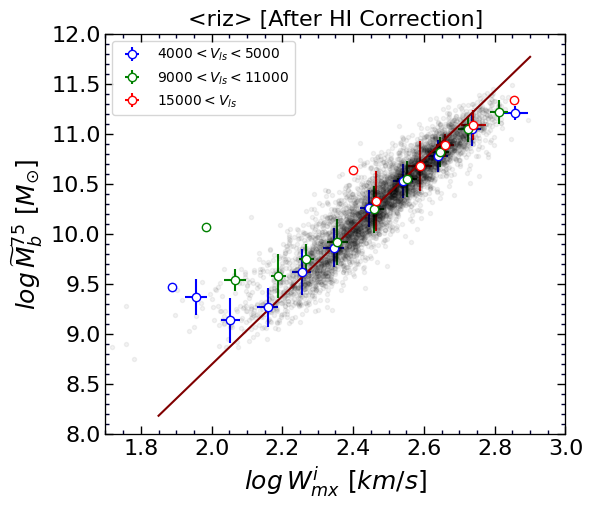

In [27]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{ls}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{ls}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{ls}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz> [After HI Correction]", fontsize=16)

ax.legend()

ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

In [28]:
Cadj_rms

array([ 6.93729862e-09, -8.50583081e-05,  5.64263060e-01, -1.36940313e+03])

In [29]:
np.random.normal(0, rms(10000, Cadj_rms[0], Cadj_rms[1], Cadj_rms[2], Cadj_rms[3]))

-0.6201013977236945

In [30]:
m0, b0, alfa, beta

(3.418, 10.405048307871825, 0.536, 1.616)

In [31]:
def getDM(mag_r, mag_i, mag_z, Wlog, F21, m0, b0, D, gi, V3k):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    
    M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
        
    alfa = 0.536
    beta = 1.616
    logXriz = beta + alfa*gi
    
    Mag_riz = -2.5*(np.log10(Mb - 1.33*M21) - logXriz)
    
    if mag_r>0 and mag_i>0 and mag_z>0:
        DM = np.nanmean([mag_r , mag_i , mag_z]) - Mag_riz
    else:
        return np.nan

    
    D = 10**((DM-25)/5)
    
    return D


def interpol(X, Y):
    
    X0 = X[~np.isnan(Y)]
    Y0 = Y[~np.isnan(Y)]
      
    N = len(X0)
    
    for i in range(N-1):
        
        if Y0[i]<0 and Y0[i+1]>0:
            break

    return -Y0[i]*(X0[i+1]-X0[i])/(Y0[i+1]-Y0[i])+X0[i]

In [32]:
Cadj_rms

array([ 6.93729862e-09, -8.50583081e-05,  5.64263060e-01, -1.36940313e+03])

In [33]:
def getDM_simul(D, mag_r, mag_i, mag_z, gi, Wlog, F21, alfa, beta, MtoLscatter, slope, zp, V3k, mc):
    
    Mb = 10**( slope*(Wlog-2.5) + zp + np.random.normal(0,0.11))
    
    M21 = 2.356E5 * F21 * (D**2)
    e = np.random.normal(0, rms(V3k, Cadj_rms[0], Cadj_rms[1], Cadj_rms[2], Cadj_rms[3]))
    M21 = 10**(np.log10(M21) + (mc)*V3k + e)
    
    logX = beta + alfa*gi + MtoLscatter   
    Mag  = -2.5*(np.log10(Mb - (1.33+np.random.normal(0, 0.1))*M21) - logX)
    
    if mag_r>0 and mag_i>0 and mag_z>0:
        mag = (mag_r+mag_i+mag_z)/3.
    else:
        return D*0. + np.nan
       
    DM = mag - Mag
    D = 10**((DM-25)/5)
    
    return D

npzName = "MLratio_riz_gi.npz"
npzfile = np.load(npzName)
samples_ = npzfile['arr_0']
samples_ = samples_[np.where(samples_[:,0]>0)]
samples_ = samples_[(samples_[:,1]>1.56)&(samples_[:,1]<2)]
samples_ = samples_[np.where(samples_[:,3]>10.25)]

alfaPool = samples_[:,0]
betaPool = samples_[:,1]
slopePool = samples_[:,2]
meanZP = np.mean(samples_[:,3])
zpPool = samples_[:,3]-meanZP+b0

n, m = samples_.shape

Nsimul = 2000

In [34]:
t1 =  datetime.now()
print(t1)

dff = df[(df.Qs>0)&(df.elgWi>0)&(df.lgWmxi>0)]
Wlog = dff.lgWmxi.values
eWlog = dff.elgWi.values
F21 = dff.F21.values
eF21 = dff.eF21.values
D75 = dff.D75.values
gi = dff.gi.values
V3k = dff.V3k.values
PGC = dff.index.values
mag_r = dff["r***"].values
mag_i = dff["i***"].values
mag_z = dff["z***"].values


N = len(dff)
DM_fid = np.zeros(N) + np.nan
eDM_fid = np.zeros(N) + np.nan
DMav_fid = np.zeros(N) + np.nan
print(N)
pp=0

for j in range(N): # range(50): #
    
    if mag_r[j]>0 and mag_i[j]>0 and mag_z[j]>0:
        D = np.arange(0.5,800,0.5)

        delta =  D - getDM(mag_r[j], mag_i[j], mag_z[j], Wlog[j], F21[j], m0, b0, D, gi[j], V3k[j])

        D = D[~np.isnan(delta)]
        delta = delta[~np.isnan(delta)]

        try:
            D_root = interpol(D, delta)
            DM_fid[j] = 5*np.log10(D_root)+25
        except:
            D_root = np.max(D[delta<0])
            DM_fid[j] = 5*np.log10(D_root)+25
            print("flag (j, pgc): ", j, PGC[j])
            pp+=1
        if j%1000==0:
            print(j, datetime.now())
    else:
        print("flag (j, pgc, nan): ", j, PGC[j])
        D_root = np.nan
        
    ## uncertainty calucaltion unit
    try:
        DMsimuls = np.zeros(Nsimul) + np.nan
        for i in range(Nsimul):
            try:

                jj = np.random.randint(n)
                D = np.arange(0.5,800,0.5)
                delta = D - getDM_simul(D, \
                                  np.random.normal(mag_r[j], 0.05), \
                                  np.random.normal(mag_i[j], 0.05), \
                                  np.random.normal(mag_z[j], 0.05), \
                                  np.random.normal(gi[j], 0.1), \
                                  np.random.normal(Wlog[j], eWlog[j]), \
                                  np.random.normal(F21[j], eF21[j]), \
                                  alfaPool[jj], betaPool[jj], \
                                  np.random.normal(0, 0.1), \
                                  slopePool[jj], np.random.normal(zpPool[jj], 0.033), \
                                  V3k[j], \
                                  np.random.normal(mc, 0.85e-05))
                D = D[~np.isnan(delta)]
                delta = delta[~np.isnan(delta)]
                try:
                    D0 = interpol(D, delta)
                    DMsimuls[i] = 5*np.log10(D0)+25
                except:
                    D0 = np.max(D[delta<0])
                    DMsimuls[i] = 5*np.log10(D0)+25
            except:
                pass    


        eDM_fid[j]  = np.std(DMsimuls)
        DMav_fid[j] = np.mean(DMsimuls)
#         print("pgc, DM, DMav, eDM : ", j, PGC[j], "%.2f"%DM_fid[j], "%.2f"%DMav_fid[j], "%.2f"%eDM_fid[j])
#         print("   ", Wlog[j], eWlog[j], F21[j], eF21[j], V3k[j], gi[j])
        
    except:
        pass
    
              
print("Number of concerning distances:", pp)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

2021-11-23 02:58:06.129651
7096
0 2021-11-23 02:58:06.138459


<ipython-input-31-9d92fd1cffc9>:13: RuntimeWarning: invalid value encountered in log10
  Mag_riz = -2.5*(np.log10(Mb - 1.33*M21) - logXriz)
<ipython-input-33-c5cc964b1042>:10: RuntimeWarning: invalid value encountered in log10
  Mag  = -2.5*(np.log10(Mb - (1.33+np.random.normal(0, 0.1))*M21) - logX)
<ipython-input-33-c5cc964b1042>:7: RuntimeWarning: invalid value encountered in log10
  M21 = 10**(np.log10(M21) + (mc)*V3k + e)


1000 2021-11-23 03:11:35.639485
flag (j, pgc, nan):  1317 23362
flag (j, pgc, nan):  1549 26317


<ipython-input-31-9d92fd1cffc9>:7: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))


flag (j, pgc, nan):  1756 28630
2000 2021-11-23 03:25:06.001682
flag (j, pgc, nan):  2966 42089
3000 2021-11-23 03:37:42.259664
flag (j, pgc, nan):  3702 51664
4000 2021-11-23 03:51:29.826164
flag (j, pgc, nan):  4261 57627
5000 2021-11-23 04:06:05.006898
6000 2021-11-23 04:20:41.458761
7000 2021-11-23 04:35:00.010212
Number of concerning distances: 0
Execution time:
1:38:09.170485


In [35]:
for j in range(N):
    
    if np.abs(DM_fid[j]-DMav_fid[j]) > 0.1:
        print(PGC[j], "%.2f"%DM_fid[j], "%.2f"%DMav_fid[j], "%.2f"%eDM_fid[j])

305 32.88 32.76 0.53
703 31.05 30.89 0.70
776 34.19 34.07 0.58
889 29.74 29.64 0.94
948 32.97 32.86 0.74
1107 30.68 30.51 0.67
1336 31.53 31.42 0.81
1525 30.83 30.67 0.69
1665 32.13 32.01 0.59
1750 30.72 30.58 0.71
1970 32.84 32.73 0.64
2228 32.99 32.88 0.53
2805 30.77 30.65 0.87
3031 32.39 32.28 0.65
3062 31.73 31.61 0.81
3250 31.66 31.52 0.77
3572 31.63 31.51 0.59
3667 31.34 31.24 0.77
3855 31.98 31.87 0.65
3974 28.27 28.09 0.80
4063 31.94 31.80 0.67
4143 31.77 31.63 0.86
4264 34.59 34.47 1.89
4805 31.93 31.80 0.70
4913 29.77 29.59 0.89
5067 32.06 31.94 0.75
5198 33.01 32.90 0.52
5242 33.18 33.07 0.74
5341 32.04 31.93 0.57
5479 32.43 32.31 0.68
5596 31.91 31.79 0.59
5600 32.45 32.35 0.57
5761 28.99 28.84 0.71
5794 31.45 31.34 0.49
6048 32.67 32.56 0.64
6228 31.33 31.22 0.55
6292 29.70 29.55 0.79
6309 30.87 30.70 0.67
6500 31.79 31.63 0.67
6574 28.45 28.29 0.83
6595 29.34 29.17 0.63
6699 28.51 28.32 0.72
6864 32.46 32.33 0.80
7262 31.54 31.40 0.56
7750 32.15 32.05 0.63
7900 30.94 30.7

43330 29.04 28.91 0.65
43450 31.50 31.31 0.96
43457 31.06 30.92 1.04
43601 32.73 32.63 0.46
43907 28.87 28.68 0.75
43961 31.51 31.35 0.88
44086 31.19 31.00 0.69
44089 30.93 30.78 0.98
44125 33.22 33.12 0.65
44961 30.80 30.67 0.98
45265 31.99 31.83 0.87
45274 30.63 30.44 0.75
45306 31.59 31.43 0.68
45311 32.94 32.83 0.56
45452 33.50 33.40 0.53
45534 33.28 33.17 0.54
45728 31.08 30.96 0.71
45807 32.75 32.61 0.72
45844 33.08 32.97 0.61
45848 31.59 31.42 0.63
45849 29.82 29.63 0.76
45858 31.20 31.08 0.54
45875 30.46 30.32 0.67
45894 33.26 33.14 0.72
46041 32.01 31.90 0.75
46159 30.84 30.68 0.94
46387 32.54 32.42 0.75
46556 30.04 29.91 0.73
46563 31.24 31.08 0.71
46636 31.27 31.11 0.71
46671 30.89 30.72 0.69
46739 30.11 29.93 0.72
46746 32.99 32.88 0.54
47027 30.62 30.51 0.55
47101 29.13 28.95 0.85
47231 33.78 33.68 0.57
47368 28.35 28.17 0.92
47371 31.37 31.25 0.91
47506 28.90 28.78 0.63
47577 29.95 29.84 0.56
47788 29.52 29.34 0.81
47904 33.27 33.15 0.68
47938 30.39 30.25 0.64
47947 30.38

(array([5.369e+03, 1.121e+03, 3.980e+02, 1.330e+02, 1.700e+01, 8.000e+00,
        3.000e+00, 5.000e+00, 1.000e+00, 1.000e+00]),
 array([0.37602827, 0.56033692, 0.74464557, 0.92895422, 1.11326287,
        1.29757152, 1.48188017, 1.66618882, 1.85049747, 2.03480612,
        2.21911477]),
 <a list of 10 Patch objects>)

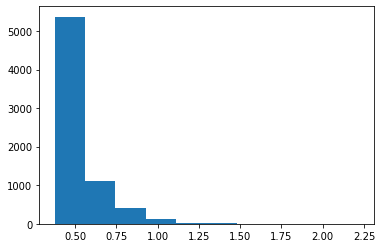

In [36]:
plt.hist(eDM_fid)

In [37]:
np.median(eDM_fid)

nan

sig_int:     0.0000   2440.3903
Computing sig_int
sig_int:     0.0000   2440.3903
sig_int:     2.4769     -0.9865
sig_int:     2.4757     -0.9865
sig_int:     1.2378     -0.9460
sig_int:     0.6189     -0.7842
sig_int:     0.3095     -0.1368
sig_int:     0.2441      0.3874
sig_int:     0.2924     -0.0331
sig_int:     0.2874      0.0010
sig_int:     0.2875     -0.0000
Computing sig_int error
sig_int:     0.2875      0.0201
sig_int:     2.4769     -0.9663
sig_int:     0.3322     -0.2308
sig_int:     0.2911     -0.0043
sig_int:     0.2905     -0.0001
sig_int:     0.2903      0.0009
Repeat at best fitting solution
sig_int:     0.2875     -0.0000
################# Values and formal errors ################
 intercept:  0.234 +/- 0.022
     slope:  0.324 +/- 0.046
   scatter:  0.2875 +/- 0.0029
Observed rms scatter: 0.29
Spearman r=0.097 and p=1e-11
Pearson r=0.098 and p=6.5e-12
##########################################################
seconds 33.24


Text(0.7, 0.05, '$b = $0.23$\\pm$0.02')

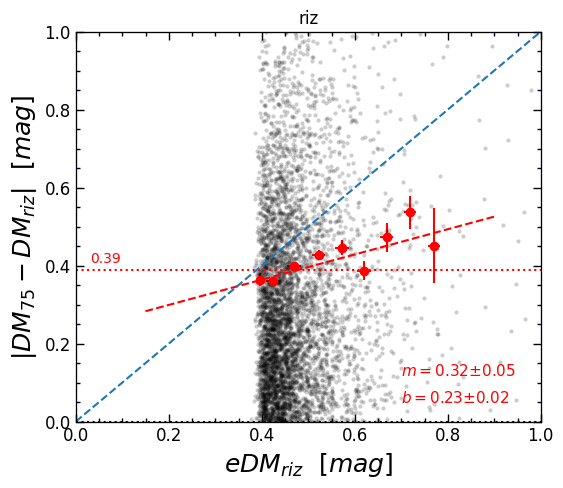

In [38]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = eDM_fid
Y = np.abs(DMav_fid - dff.DM_75.values)

V3k = dff.V3k.values
X0 = X[V3k>4000]
Y0 = Y[V3k>4000]

ax.plot(X0, Y0, 'k.', alpha=0.2, mfc='k', mec='none')

X = X0[Y0<1.]
Y = Y0[Y0<1.]

factor = np.sqrt(np.pi/2.)
for i in np.arange(0.15,0.8,0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        yp *= factor
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.std(yp)/np.sqrt(len(yp)), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)  
        
ax.set_ylabel(r'$|DM_{75} - DM_{riz}| \/\/\/\/ [mag]$', fontsize=18)
ax.set_xlabel(r'$eDM_{riz} \/\/\/\/ [mag]$', fontsize=18)

ax.plot([0,1], [0,0], ':', color='k')

set_axes(ax, (0,1), (0,1), fontsize=12)

ax.set_title("riz")

from ltsfit.lts_linefit import lts_linefit
mcfit = lts_linefit(X, factor*Y, X*0+0.001, Y*0+0.001, clip=3., plot=False)
xx = np.linspace(0.15,0.9,100)
ax.plot(xx, mcfit.ab[1]*xx+mcfit.ab[0], '--', color='red')

yy0 = np.mean(factor*Y0[Y0<1.0])
ax.text(0.03,yy0+0.02, "%.2f"%yy0, color='red')
ax.plot([0,1],[yy0,yy0], ':', color='red')
ax.plot([0,1],[0,1], '--', color='#1f77b4')


ax.text(0.7,0.12, r"$m = $"+"%.2f" % mcfit.ab[1]+'$\pm$'+"%.2f" % mcfit.ab_err[1], fontsize=11, color='red')
ax.text(0.7,0.05, r"$b = $"+"%.2f" % mcfit.ab[0]+'$\pm$'+"%.2f" % mcfit.ab_err[0], fontsize=11, color='red')


<ipython-input-39-a6b7ab2da156>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['dDM'] = DM_fid - dff.DM_75.values
<ipython-input-39-a6b7ab2da156>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['DMriz_fid'] = DM_fid
<ipython-input-39-a6b7ab2da156>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Text(0.5, 1.0, '<riz>')

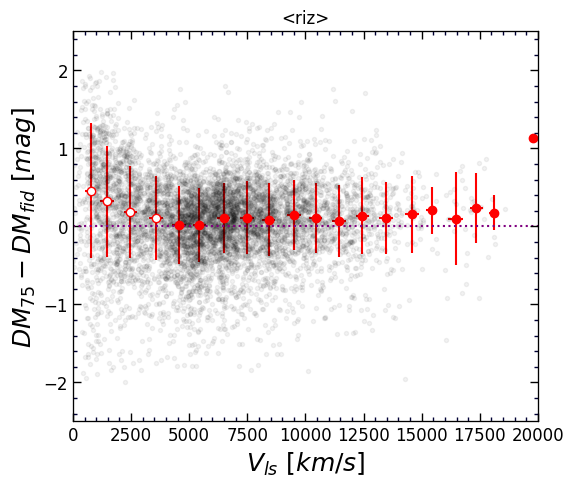

In [39]:
dff['dDM'] = DM_fid - dff.DM_75.values
dff['DMriz_fid'] = DM_fid
dff['DMav_riz'] = DMav_fid
dff['eDM_riz'] = eDM_fid
eDM_adj = mcfit.ab[1]*eDM_fid+mcfit.ab[0]
for jj in range(len(eDM_fid)):
    if eDM_fid[jj]>eDM_adj[jj]:
        eDM_adj[jj]=eDM_fid[jj]
#     if eDM_adj[jj]<yy0:
#         eDM_adj[jj] = yy0 
dff['eDM_riz_adj'] = eDM_adj
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k.values
Y = dff.dDM.values
# logW = dff.lgWmxi.values

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   


for i in np.arange(0,4000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

ax.set_title("<riz>")

In [40]:
np.mean(Y[X>4000])

0.04010887359245473

Text(0.5, 1.0, '<riz>')

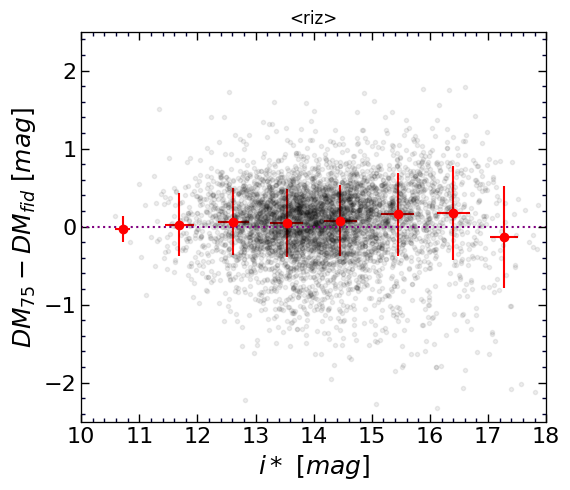

In [41]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


dff_ = dff[dff.V3k>4000]

X = dff_['i***'].values
Y = dff_.dDM.values
V = dff_.V3k.values

ax.plot(X, Y, 'k.', alpha=0.07)

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-2.5,2.5))

ax.set_title("<riz>")

In [42]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)))
dff['logMb'] = np.log10(dff.Mb.values)


dff[['DM_75', 'DMriz_fid', 'Mass_HI', 'Ms_riz', 'Mb', 'F21', 'eF21', 'Qs', 'DMav_riz', 'eDM_riz', 'eDM_riz_adj']].to_csv("MLratio_riz_distances.csv")

<ipython-input-42-3aa053a6668f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-42-3aa053a6668f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)))
<ipython-input-42-3aa053a6668f>:3: SettingWithCopy

<ipython-input-43-56dc55f5e058>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
<ipython-input-43-56dc55f5e058>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)+HI_corrector(mc, 0, dff.V3k.values)))
<ipython-input-43-56dc55f5e058>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

(3.418, 10.405048307871825)

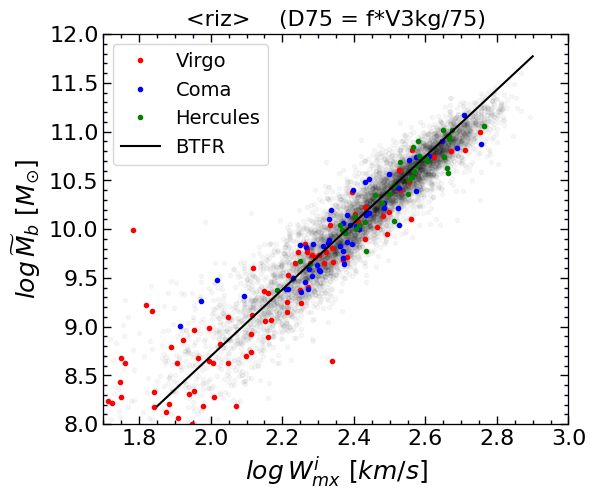

In [43]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)+HI_corrector(mc, 0, dff.V3k.values)))
dff['logMb'] = np.log10(dff.Mb.values)

######################################################################
dff = dff.rename(columns={"1PGC": "PGC1"})


df_vrigo = dff[dff.PGC1==41220]
df_coma = dff[dff.PGC1==44715]
df_herc = dff[dff.PGC1==56962]

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(logW, logMass, '.', color='black', alpha=0.03) 


ax.plot(df_vrigo.lgWmxi, df_vrigo.logMb, 'r.', label='Virgo')
ax.plot(df_coma.lgWmxi, df_coma.logMb, 'b.', label='Coma')
ax.plot(df_herc.lgWmxi, df_herc.logMb, 'g.', label='Hercules')

ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)

set_axes(ax, (1.7,3), (8,12))
ax.set_title("<riz>    (D75 = f*V3kg/75)", fontsize=16)

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, 'k-', label='BTFR')

ax.legend(fontsize=14, loc=2)   

m0, b0

In [44]:
len(dff)

7096

In [45]:
s = 1

dist = np.random.normal(-1, s, 1000000)

s/np.mean(np.abs(dist))

0.8578437468530942

(array([0.000e+00, 0.000e+00, 4.370e+03, 1.793e+03, 5.610e+02, 2.370e+02,
        6.400e+01, 1.700e+01, 4.000e+00]),
 array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
        0.83333333, 1.        , 1.16666667, 1.33333333, 1.5       ]),
 <a list of 9 Patch objects>)

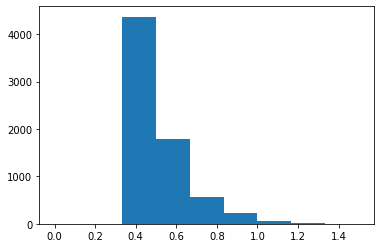

In [46]:
plt.hist(np.sqrt(dff.eDM_riz.values**2+0.0**2), bins=np.linspace(0,1.5,10))

In [47]:
np.sqrt(0.38**2-0.1**2)


0.3666060555964672